<a href="https://colab.research.google.com/github/pesesu/chat-app/blob/main/Tuberculosis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [54]:
DATASET_PATH = 'gdrive/MyDrive/'

In [55]:
!ls {DATASET_PATH}

'Colab Notebooks'   tuberculosis   tuberculosis_model.h5  'Untitled document.gdoc'


## Step 1: Load and Preprocess the Images

Found 978 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 142 images belonging to 2 classes.


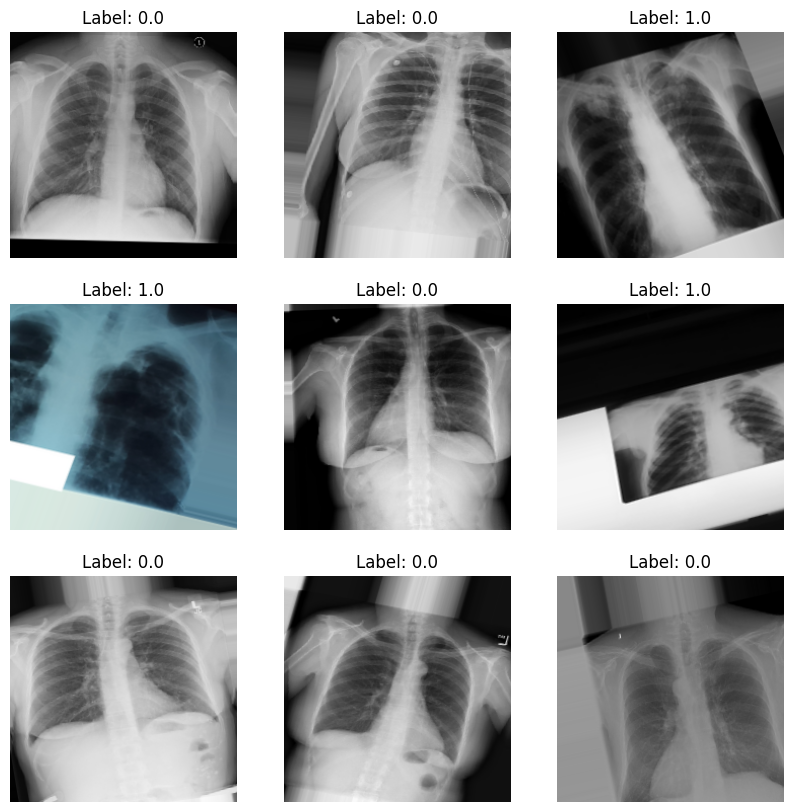

In [56]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths
train_dir = f'{DATASET_PATH}/tuberculosis/train'
val_dir = f'{DATASET_PATH}/tuberculosis/validation'
test_dir = f'{DATASET_PATH}/tuberculosis/test'

# ImageDataGenerator for preprocessing and data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load train, validation, and test datasets
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')

val_generator = val_test_datagen.flow_from_directory(val_dir,
                                                     target_size=(224, 224),
                                                     batch_size=32,
                                                     class_mode='binary')

test_generator = val_test_datagen.flow_from_directory(test_dir,
                                                      target_size=(224, 224),
                                                      batch_size=32,
                                                      class_mode='binary')

# Display some training images
def display_images(generator):
    images, labels = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title("Label: " + str(labels[i]))
        plt.axis('off')
    plt.show()

display_images(train_generator)

In [57]:
# Data Augumentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

## Step 2: Set Up the Transfer Learning Model

In [58]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop

# Load the base model
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model

inputs = base_model.output
x = data_augmentation(inputs)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), #RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_6[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

In [59]:
train_generator.image_shape

(224, 224, 3)

## Step 3: Train the Model

In [60]:
# Train the model
history = model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator)

Epoch 1/10
31/31 [==============================] - 29s 846ms/step - loss: 0.3524 - accuracy: 0.8374 - val_loss: 0.3579 - val_accuracy: 0.8286
Epoch 2/10
31/31 [==============================] - 25s 816ms/step - loss: 0.1184 - accuracy: 0.9509 - val_loss: 0.3677 - val_accuracy: 0.8321
Epoch 3/10
31/31 [==============================] - 25s 811ms/step - loss: 0.0813 - accuracy: 0.9714 - val_loss: 0.2574 - val_accuracy: 0.8964
Epoch 4/10
31/31 [==============================] - 24s 784ms/step - loss: 0.0840 - accuracy: 0.9714 - val_loss: 0.1602 - val_accuracy: 0.9500
Epoch 5/10
31/31 [==============================] - 25s 783ms/step - loss: 0.0587 - accuracy: 0.9734 - val_loss: 0.2436 - val_accuracy: 0.9000
Epoch 6/10
31/31 [==============================] - 25s 820ms/step - loss: 0.0674 - accuracy: 0.9734 - val_loss: 0.4287 - val_accuracy: 0.8250
Epoch 7/10
31/31 [==============================] - 25s 815ms/step - loss: 0.0500 - accuracy: 0.9826 - val_loss: 0.4258 - val_accuracy: 0.8429

## Step 4: Evaluate the Model

In [61]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

5/5 [==============================] - 2s 295ms/step - loss: 0.3368 - accuracy: 0.8944
Test accuracy: 0.8943662047386169


## Step 5: Display Plots

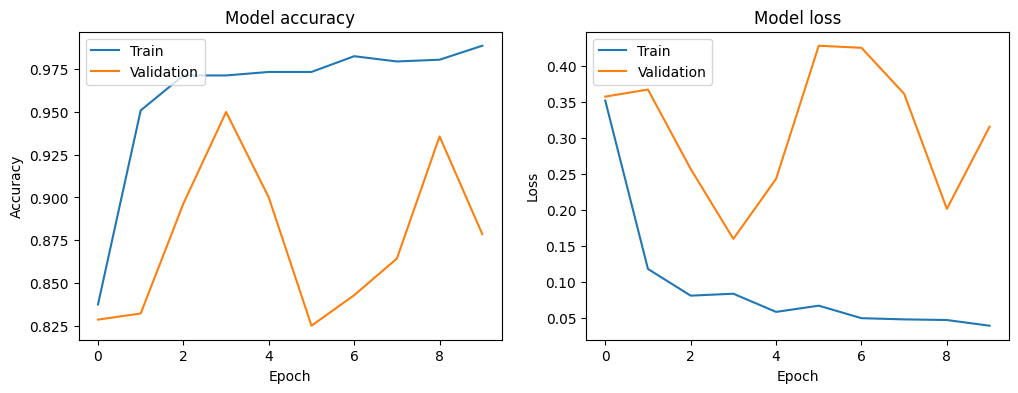

In [62]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [64]:
model.save('tuberculosis_model.h5')